In [1]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import configparser
import os
from pathlib import Path
import json

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
config = configparser.ConfigParser()
config.read('../_system.ini')
system_info = config['system_info']

2022-09-19 12:43:44.287253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 12:43:44.287277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-19 12:43:46.838777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 12:43:46.838821: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 12:43:46.838843: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist


# Data

(42, 24, 1632)
Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Documents/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


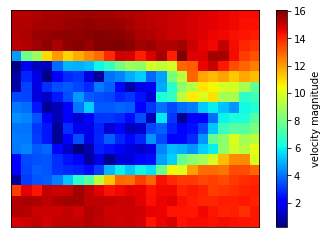

In [2]:
#=================== downsampled data ======================
ny = 21
nz = 24
filename = '../data/u_shuffle_1632.h5'
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
vy = x[:,:,:,0]
vz = x[:,:,:,1]
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
print(X.shape)
V = (x[:,:,:,0]**2 + x[:,:,:,1]**2)**0.5

pod_v = md.POD(X,method='classic')
Q_POD_v,lam_v = pod_v.get_modes
Q_mean_v = pod_v.Q_mean
modes_data = np.reshape(Q_POD_v,(2*ny,nz,1008))

fig = plt.figure()
plt.imshow(V[:,:,0],'jet')
cbar = plt.colorbar()
cbar.set_label('velocity magnitude')
plt.xticks([])
plt.yticks([])
plt.show()


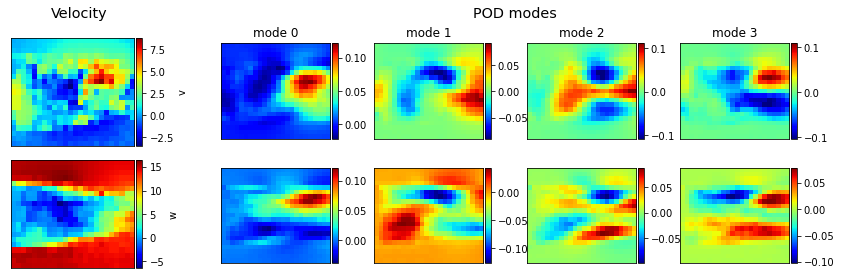

In [3]:
fig = plt.figure(figsize=(10,4))
ax1 = ImageGrid(fig,(0.3,0.05,0.8,0.8),(2,4),axes_pad=(0.5,0.4), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
ax2 = ImageGrid(fig,(0.0,0.05,0.2,0.8),(2,1),axes_pad=(0.5,0.2), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
fig.text(0.65,0.92,'POD modes',fontsize='x-large')
fig.text(0.065,0.92,'Velocity',fontsize='x-large')

cax1 = ax1.cbar_axes
cax2 = ax2.cbar_axes
im1 = ax2[0].imshow(vy[:,:,0],'jet')
# ax2[0].set_ylabel('v')
cax2[0].colorbar(im1,label='v')
im2 = ax2[1].imshow(vz[:,:,1],'jet')
# ax2[1].set_ylabel('w')
cax2[1].colorbar(im2,label='w')
ax2[1].set(yticks=[],xticks=[])

for i in range(4):
    im1 = ax1[i].imshow(modes_data[:ny,:,i],'jet')
    cax1[i].colorbar(im1)
    ax1[i].set_title(f'mode {i}')
    im2 = ax1[i+4].imshow(modes_data[ny:,:,i],'jet')
    cax1[i+4].colorbar(im2)
ax1[0].set(yticks=[],xticks=[])
plt.show()

# Hierarchical autoencoder

In [173]:
folder = Path(system_info['save_location'],'Hierarchical_10_1__2022_05_10__15_09_47-linear')
filename = Path(folder,'results.h5')
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
hist_val = np.array(hf.get('hist_val'))
u_avg = np.array(hf.get('u_avg'))
latent_test = np.array(hf.get('latent_test')) # shape [latent_variable, test_snapshots, 1]
y_test = np.array(hf.get('y_test')) # [modes,nt,ny,nz,nu]
hf.close()
latent_test = np.squeeze(latent_test).T # shape [snapshots, latent_variable]

filename = Path(folder,'Model_param.h5')
hf = h5py.File(filename,'r')
Ny = int(hf.get('Ny')[()])
Nz = int(hf.get('Nz')[()])
Nu = int(hf.get('Nu')[()])
features_layers = np.array(hf.get('features_layers')).tolist()
no_of_modes = int(hf.get('no_of_modes')[()])
latent_dim = int(hf.get('latent_dim')[()])
resize_meth = hf.get('resize_meth')[()].decode()
filter_window = np.array(hf.get('filter_window')).tolist()
act_fct = hf.get('act_fct')[()].decode()
batch_norm = hf.get('batch_norm')[()]
drop_rate = hf.get('drop_rate')[()]
lmb = hf.get('lmb')[()]
idx_unshuffle = np.array(hf.get('idx_unshuffle'))
hf.close()
Nx = [Ny,Nz]

# load the last network
mdl_in = [u_test]
for i in range(no_of_modes-1):
    mdl_in.append(np.reshape(latent_test[:,i],(-1,1)))

lst = [1]*(no_of_modes-1)
mdl = mdl_nobias.HierarchicalAE_sub(Nx=Nx,Nu=Nu,previous_dim=lst,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)
mdl.compile(optimizer='adam',loss='mse')
_ = mdl.evaluate(mdl_in,u_test)
weights = Path(folder, 'subnet'+str(no_of_modes)+'.h5')
mdl.load_weights(weights)
_ = mdl.evaluate(mdl_in,u_test)
last_decoder = mdl.get_decoder()

# calculate modes sum method
modes_test = y_test - np.insert(y_test,0,np.zeros_like(y_test[0]),axis=0)[:no_of_modes,:,:,:,:]
print(modes_test.shape)

# POD of hierarchical modes
vy = modes_test[0,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = modes_test[0,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
pod = md.POD(X,method='classic')
Q_POD,lam = pod.get_modes
modes_1 = np.reshape(Q_POD,(2*ny,nz,1008))
energy_1 = lam/np.sum(lam)

vy = modes_test[2,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = modes_test[2,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
pod = md.POD(X,method='classic')
Q_POD,lam = pod.get_modes
modes_2 = np.reshape(Q_POD,(2*ny,nz,1008))
energy_2 = lam/np.sum(lam)
print(modes_2.shape)

19/19 [==============================] - 0s 8ms/step - loss: 1.1722
(10, 600, 21, 24, 2)
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
(42, 24, 1008)


/home/ym917/Documents/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


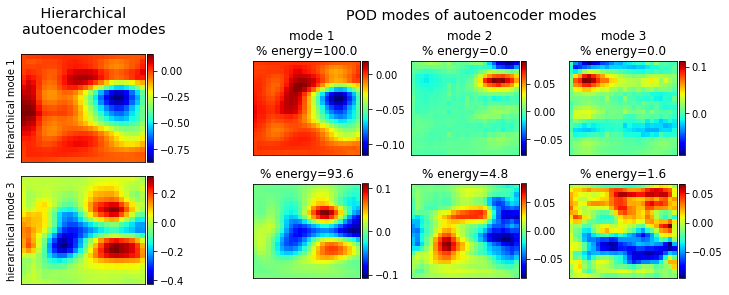

In [192]:
fig = plt.figure(figsize=(10,4))
ax1 = ImageGrid(fig,(0.4,0.05,0.6,0.8),(2,3),axes_pad=(0.6,0.4), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
ax2 = ImageGrid(fig,(0.07,0.05,0.2,0.8),(2,1),axes_pad=(0.5,0.2), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
fig.text(0.53,0.97,'POD modes of autoencoder modes',fontsize='x-large')
fig.text(0.08,0.92,'    Hierarchical \nautoencoder modes',fontsize='x-large')
ax1[0].set(yticks=[],xticks=[])
ax2[1].set(yticks=[],xticks=[])
cax1 = ax1.cbar_axes
cax2 = ax2.cbar_axes

im1 = ax2[0].imshow(modes_test[0,0,:,:,0],'jet')
ax2[0].set_ylabel('hierarchical mode 1')
cax2[0].colorbar(im1)
im2 = ax2[1].imshow(modes_test[2,0,:,:,0],'jet')
ax2[1].set_ylabel('hierarchical mode 3')
cax2[1].colorbar(im2)

for i in range(3):
    im1 = ax1[i].imshow(modes_1[ny:,:,i],'jet')
    cax1[i].colorbar(im1)
    ax1[i].set_title('%% energy=%0.1f'%(energy_1[i]*100))
    # ax1[i].set_title(f'mode {i+1}')
    im2 = ax1[i+3].imshow(modes_2[ny:,:,i],'jet')
    cax1[i+3].colorbar(im2)
    ax1[i+3].set_title('%% energy=%0.1f'%(energy_2[i]*100))
fig.text(0.45,0.9,'mode 1                             mode 2                            mode 3',fontsize='large')
plt.show()

# Linear experiments

In [202]:
parent_folder = '/home/ym917/Documents/Results/experiment_linear_samedata'
experiments = ['u_bias3-3598028','ufluc_bias14-853358','u_nobias6-249321','ufluc_nobias21-1438472']

In [203]:
print(modes_data.shape)

(42, 24, 1008)


In [289]:
weights_1 = []
weights_2 = [] # (experiment, 1, 21, 24, 2)
b = [] # (experiment, 1, 21, 24, 2)
# modes_no_bias (2, 1632, 21, 24, 2)
equivalent_pca = []

for i in range(4):
    filename = Path(parent_folder,experiments[i],'results.h5')
    with h5py.File(filename,'r') as hf:
        modes_train = np.array(hf.get('modes_train'))
    filename = Path(parent_folder,experiments[i],'training_param.ini')
    linear = TrainNN_from_config(filename)


    # modes without bias
    if linear.NO_BIAS:
        modes_train_nobias = modes_train
        mdl = mdl_nobias.Autoencoder(linear.Nx,linear.Nu,linear.features_layers,linear.latent_dim,linear.filter_window, linear.act_fct, linear.BATCH_NORM, linear.drop_rate, linear.lmb)
        mdl.compile(optimizer=Adam(learning_rate=linear.learning_rate),loss='mse')
        _ = mdl.predict(np.squeeze(u_train))
        filename = Path(parent_folder,experiments[i],'md_ae_model.h5')
        mdl.load_weights(filename)
        w1 = mdl.decoder.predict(np.reshape([1,0],(1,2)))
        w2 = mdl.decoder.predict(np.reshape([0,1],(1,2)))
        add_bias = None
    elif linear.NO_BIAS is False:
        mdl = mdl_bias.Autoencoder(linear.Nx,linear.Nu,linear.features_layers,linear.latent_dim,linear.filter_window, linear.act_fct, linear.BATCH_NORM, linear.drop_rate, linear.lmb)
        mdl.compile(optimizer=Adam(learning_rate=linear.learning_rate),loss='mse')
        _ = mdl.predict(np.squeeze(u_train))
        filename = Path(parent_folder,experiments[i],'md_ae_model.h5')
        mdl.load_weights(filename)

        bias = mdl.decoder.predict(np.zeros((1,linear.latent_dim)))
        modes_train_nobias = modes_train - np.squeeze(bias)
        w1 = mdl.decoder.predict(np.reshape([1,0],(1,2))) - bias
        w2 = mdl.decoder.predict(np.reshape([0,1],(1,2))) - bias
        add_bias = (bias[0,:,:,0]**2 + bias[0,:,:,1]**2)**0.5
    
    weights_1.append(w1)
    weights_2.append(w2)
    b.append(add_bias)


    # reproject autoencoder modes onto data pod modes
    lam_modes = mode_eval.equivalent_pca_energy(modes_train_nobias,Q_POD_v)
    equivalent_pca.append(lam_modes)

In [290]:
weights_1 = np.array(weights_1)# (experiment, 1, 21, 24, 2)
weights_2 = np.array(weights_2)
x_axis = np.arange(1,linear.Nz*linear.Ny*linear.Nu+1)


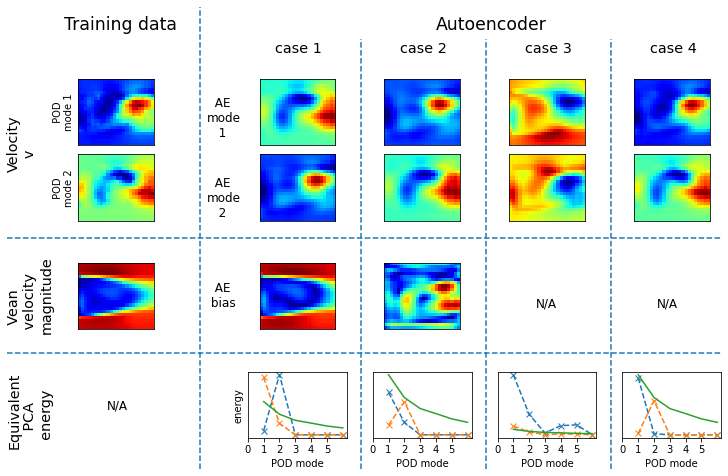

In [392]:
fig = plt.figure(5,figsize=(10,6.5),constrained_layout=True)
figax = fig.add_subplot(111)
figax.set(ylim=[0,1],xlim=[0,1])
figax.axis('off')

gs = fig.add_gridspec(12,12,hspace=0.0,wspace=0.0)

space_top = fig.add_subplot(gs[:2,:])
space_top.axis('off')

axdata0 = fig.add_subplot(gs[2:4,1:3])
axdata0.set(xticks=[],yticks=[])
axdata1 = fig.add_subplot(gs[4:6,1:3])
axdata1.set(xticks=[],yticks=[])
axdata2 = fig.add_subplot(gs[7:9,1:3])
axdata2.set(xticks=[],yticks=[])

ax_mode = []
for y in [2,4]:
    for x in range(4,11,2):
        ax = fig.add_subplot(gs[y:y+2,x:x+2])
        ax_mode.append(ax)
        ax.set(xticks=[],yticks=[])
ax_mean = []
for x in [4,6]:
    ax = fig.add_subplot(gs[7:9,x:x+2])
    ax_mean.append(ax)
    ax.set(xticks=[],yticks=[])
ax_pca = []
for x in [4,6,8,10]:
    ax = fig.add_subplot(gs[10:12,x:x+2])
    ax_pca.append(ax)

# plot
for ex in range(4):
    ax_mode[ex].imshow(weights_1[ex,0,:,:,0],'jet')
    ax_mode[ex+4].imshow(weights_2[ex,0,:,:,0],'jet')
    for n_modes in range(2):
        ax_pca[ex].plot(x_axis[:6],equivalent_pca[ex][n_modes,:6],label=n_modes+1,linestyle='--',marker='x')
    ax_pca[ex].plot(x_axis[:6],lam_v[:6],label='data')
    ax_pca[ex].set(xticks=range(6),yticks=[],xlabel='POD mode')
for ex in range(2):
    ax_mean[ex].imshow(b[ex],'jet')
ax_pca[0].set_ylabel('energy')

axdata0.imshow(modes_data[:ny,:,0],'jet')
axdata0.set_ylabel(' POD \nmode 1')
axdata1.imshow(modes_data[:ny,:,1],'jet')
axdata1.set_ylabel(' POD \nmode 2')
axdata2.imshow(np.mean(V,axis=-1),'jet')


figax.text(0,0.65,'Velocity\n   v',fontsize='x-large',rotation=90)
figax.text(0,0.3,'  Vean\n velocity\nmagnitude',fontsize='x-large',rotation=90)
figax.text(0,0.05,'Equivalent\n    PCA\n  energy',fontsize='x-large',rotation=90)
figax.text(0.6,0.95,'Autoencoder',fontsize='xx-large')
figax.text(0.08,0.95,'Training data',fontsize='xx-large')
figax.text(0.28,0.72,'  AE\nmode\n   1',fontsize='large')
figax.text(0.28,0.545,'  AE\nmode\n   2',fontsize='large')
figax.text(0.28,0.35,'  AE\n bias',fontsize='large')
figax.text(0.375,0.9,'case 1',fontsize='x-large')
figax.text(0.55,0.9,'case 2',fontsize='x-large')
figax.text(0.725,0.9,'case 3',fontsize='x-large')
figax.text(0.9,0.9,'case 4',fontsize='x-large')


figax.text(0.14,0.13,'N/A',fontsize='large')
figax.text(0.74,0.35,'N/A',fontsize='large')
figax.text(0.91,0.35,'N/A',fontsize='large')

figax.hlines(y=0.5,xmin=0,xmax=1,linestyles='--')
figax.hlines(y=0.25,xmin=0,xmax=1,linestyles='--')
figax.vlines(x=0.27,ymin=0,ymax=1,linestyles='--')
figax.vlines(x=0.495,ymin=0,ymax=0.93,linestyles='--')
figax.vlines(x=0.67,ymin=0,ymax=0.93,linestyles='--')
figax.vlines(x=0.845,ymin=0,ymax=0.93,linestyles='--')


plt.show()